 <h1><center>Dairy Diary - a Log Book for Grazing Cows</center></h1>

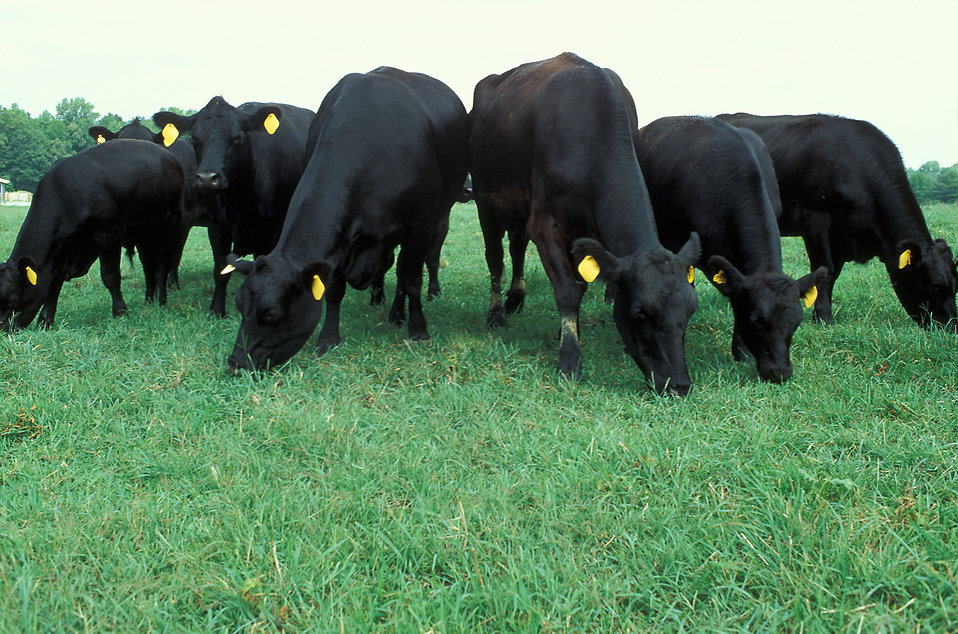

In [1]:
from IPython import display 
display.Image("C:\\Users\\Jens Harbers\\Documents\\grazing_cows_s.jpg")

 <h1><center>Introduction</center></h1>

- Farmers are supposed to note where and when a cows grazed at a given day.

- Used for some special programmes (Weidemilchprogramm)

- This is a tedious task

- Goal: Automatisation with no costs and easy as possible



 <h1><center>1. Load Libraries</center></h1>

In [18]:
import pandas as pd
import geopandas as gpd
print("Version of Pandas:",pd.__version__)
print("Version of GeoPandas:",gpd.__version__)

Version of Pandas: 1.0.3
Version of GeoPandas: 0.6.1


<h1><center>2. Read Log File</center></h1>

In [19]:
df = pd.read_csv("firstone_logs.csv")
df.head(5)

,Unnamed: 0,alarm,batV,device_id,latitude,longitude,pitch,raw,roll,time
0,0,False,3.574,firstone,NaN,NaN,-5.48,AAAAAAAADfb5PP3c,-17.32,2020-10-16T19:48:10.040935193Z
1,1,False,4.021,firstone,53.5778,8.3138,6.97,CCziAUTCD7X/qgK5,-0.86,2020-10-17T04:39:05.800845065Z
2,2,False,4.015,firstone,53.578,8.3133,7.0,CCzkAUS9D6//qAK8,-0.88,2020-10-17T04:42:43.814355462Z
3,3,False,4.015,firstone,53.5761,8.3144,7.02,CCzRAUTID6//pgK+,-0.9,2020-10-17T04:46:07.81233729Z
4,4,False,4.019,firstone,53.5768,8.3143,7.02,CCzYAUTHD7P/pgK+,-0.9,2020-10-17T04:49:33.803516885Z


<h1><center>3. Prepare Log File</center></h1>

In [20]:
df = df.drop_duplicates()
df = df[df.time!="time"] # remove lines with 'time' in column time
df.time = pd.to_datetime(df.time) # convert to datetime
df = df.set_index(df["time"]) # use timestamp as an index for aggregating
df = df.iloc[1:,] # remove first line as there is an NAN

In [21]:
# convert coordinates into float
df.longitude = df["longitude"].astype(float)
df.latitude = df["latitude"].astype(float)

<h1><center>4. Convert pd.DataFrame to gpd.DataFrame</center></h1>

In [22]:
pointlist = gpd.GeoDataFrame(df,crs="EPSG:4326", geometry=gpd.points_from_xy(df["longitude"], df["latitude"]))

In [23]:
fields = gpd.read_file("C:\\Users\\Jens Harbers\\Documents\\skizzen\\gfn_schlaege.shp")

In [24]:
fields.head(5)

,OBJEKT_ID,REG_NR,FLIK,JAHR,SCHLAG_NR,geometry
0,170,1,DENI041234567,2014,170,"POLYGON ((454853.526 5936721.447, 454875.776 5..."
1,70,2,DENI041234568,2014,70,"POLYGON ((454459.338 5937007.829, 454500.103 5..."
2,100,3,DENI041234569,2014,100,"POLYGON ((454984.613 5936868.884, 455000.704 5..."
3,200,4,DENI041234570,2014,200,"POLYGON ((454798.590 5936988.270, 454936.701 5..."
4,140,5,DENI041234571,2014,140,"POLYGON ((454901.872 5936324.231, 454904.011 5..."


In [25]:
my_fields = fields[fields.OBJEKT_ID<360] # remove unneeded piece of land

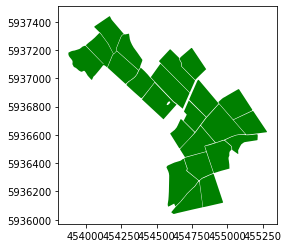

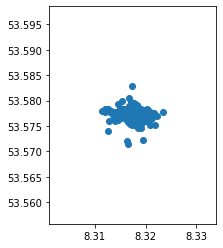

In [26]:
my_fields.plot(color="green")
pointlist.plot()

<h1><center>4. Align Coordinate Reference System (CRS)</center></h1>

In [27]:
my_fields.crs = "epsg:25832" # initial CRS (as no projection file is delivered, feel free to find out CRS)
my_fields = my_fields.to_crs("EPSG:4326")
print(my_fields.crs == pointlist.crs)

True


In [28]:
df = gpd.sjoin(pointlist,my_fields)

C:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


<h1><center>5. Aggregation by Time and Lot </center></h1>

In [29]:
df = df[["SCHLAG_NR","time"]].groupby(by=[df['time'].dt.date,"SCHLAG_NR"]).count()
df.head(15)

time
time       SCHLAG_NR      
2020-10-17 60           10
           80            1
           170           7
           190           9
           200           2
           210          15
           220         202
2020-10-18 100           6
           130           2
           170          14
           190          11
           200           9
           220         408
2020-10-19 130           1
           170           3

In [30]:
df = df.groupby(level=0).tail(1)
df.head(5)

,,time
time,SCHLAG_NR,
2020-10-17,220,202
2020-10-18,220,408
2020-10-19,220,446
2020-10-20,220,420
2020-10-21,220,450


<h1><center>6. Export Dairys Diary</center></h1>

In [28]:
df.to_excel("dairy_diary.xlsx")